In [ ]:
# Load required dependencies and files
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from collections import OrderedDict
from scipy.special import softmax
from scipy.signal import chirp, find_peaks, peak_widths
from torch import nn
from torch.utils.checkpoint import checkpoint
from scipy.stats import spearmanr
import statistics
import csv
from statistics import mean
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'
import torch
from torch.autograd import grad
import selene_sdk
import scipy
import seaborn as sns

#load genome file
genome_hg19 = selene_sdk.sequences.Genome(input_path='./resources/hg37/Homo_sapiens.GRCh37.75.dna.primary_assembly.fa',)
#load file with oligoomer sequences
sequence_pd = pd.read_csv('./resources/TATA_NFY_mutations_STEP_seq/GSM5582242_STAPseq_input_TATA_CCAATbox_library.txt', sep='\t')
#load file with STAP seq count measurements
sequence_count = pd.read_csv('./resources/TATA_NFY_mutations_STEP_seq/GSM5582238_STAPseq_BRD4_msAuxin_TATA_CAATbox_library_rep1_counts_per_pos.txt', sep='\t')
#load plasmid sequences
plasmid1 = 'ccgggagtactgtcctccgagcggagtactgtcctccgagcgggaagcttgcatgcctgcaggtcggagtactgtcctccgagcggagtactgtcctccgaggacccagctttcttgtacaaagtggtagatcttagagcatgcaccgg'
plasmid2 = 'tcgacgaattcggcccctgcaggggcattccggtactgttggtaaagccaccatggaagtaagtatcaaggttacaagacaggtttaaggagaccaatagaaactgggcttgtcgagacagagaagactcttgcgtttctgataggcacctattggtcttactgacatccactttgcctttctctccacagccacttaagcatggctagcaaaggagaagaactcttcactggagttgtcccaattcttgttgaattagatggtgatgttaacggccacaagttctctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttaccctgaagttcatctgcactactggcaaactgcctgttccctggccaacactagtctgatctagagtcggggcggccggccgcttcgagcagacatgataagatacattgatgagtttggacaaaccacaactagaatgcagtgaaaaaaatgctttatttgtgaaatttgtgatgctattgctttatttgtaaccattataagctgcaataaacaagttaacaacaacaattgcattcattttatgtttcaggttcagggggaggtgtgggaggttttttaaagcaagtaaaacctctacaaatgtggtaaaatcgataaggatccgaccgatgccctcaagctttgagaggggcccccttcaacccagtcagctccgacgtcttggcgcccccgcggggcatgactatcgtcgtcgcacttatgactgtcttctttatcatgcaactcgtaggacaggtgccggcagcgctcttccgcttcctcgctcactgactcgctgcgctcggtcgttcggctgcggcgagcggtatcagctcactcaaaggcggtaatacggttatccacagaatcaggggataacgcaggaaagaacatgtgagcaaaaggccagcaaaaggccaggaaccgtaaaaaggccgcgttgctggcgtttttccataggctccgcccccctgacgagcatcacaaaaatcgacgctcaagtcagaggtggcgaaacccgacaggactataaagataccaggcgtttccccctggaagctccctcgtgcgctctcctgttccgaccctgccgcttaccggatacctgtccgcctttctcccttcgggaagcgtggcgctttctcatagctcacgctgtaggtatctcagttcggtgtaggtcgttcgctccaagctgggctgtgtgcacgaaccccccgttcagcccgaccgctgcgccttatccggtaactatcgtcttgagtccaacccggtaagacacgacttatcgccactggcagcagccactggtaacaggattagcagagcgaggtatgtaggcggtgctacagagttcttgaagtggtggcctaactacggctacactagaagaacagtatttggtatctgcgctctgctgaagccagttaccttcggaaaaagagttggtagctcttgatccggcaaacaaaccaccgctggtagcggtggtttttttgtttgcaagcagcagattacgcgcagaaaaaaaggatctcaagaagatcctttgatcttttctacggggtctgacgctcagtggaacgaaaactcacgttaagggattttggtcatgagattatcaaaaaggatcttcacctagatccttttaaattaaaaatgaagttttaaatcaatctaaagtatatatgagtaaacttggtctgacagcggccgcaaatgctaaaccactgcagtggttaccagtgcttgatcagtgaggcaccgatctcagcgatctgcctatttcgttcgtccatagtggcctgactccccgtcgtgtagatcactacgattcgtgagggcttaccatcaggccccagcgcagcaatgatgccgcgagagccgcgttcaccggcccccgatttgtcagcaatgaaccagccagcagggagggccgagcgaagaagtggtcctgctactttgtccgcctccatccagtctatgagctgctgtcgtgatgctagagtaagaagttcgccagtgagtagtttccgaagagttgtggccattgctactggcatcgtggtatcacgctcgtcgttcggtatggcttcgttcaactctggttcccagcggtcaagccgggtcacatgatcacccatattatgaagaaatgcagtcagctccttagggcctccgatcgttgtcagaagtaagttggccgcggtgttgtcgctcatggtaatggcagcactacacaattctcttaccgtcatgccatccgtaagatgcttttccgtgaccggcgagtactcaaccaagtcgttttgtgagtagtgtatacggcgaccaagctgctcttgcccggcgtctatacgggacaacaccgcgccacatagcagtactttgaaagtgctcatcatcgggaatcgttcttcggggcggaaagactcaaggatcttgccgctattgagatccagttcgatatagcccactcttgcacccagttgatcttcagcatcttttactttcaccagcgtttcggggtgtgcaaaaacaggcaagcaaaatgccgcaaagaagggaatgagtgcgacacgaaaatgttggatgctcatactcgtcctttttcaatattattgaagcatttatcagggttactagtacgtctctcaaggataagtaagtaatattaaggtacgggaggtattggacaggccgcaataaaatatctttattttcattacatctgtgtgttggttttttgtgtgaatcgatagtactaacatacgctctccatcaaaacaaaacgaaacaaaacaaactagcaaaataggctgtccccagtgcaagtgcaggtgccagaacatttctctggcctaactggccggtacctgagctcgctagcctcgaggatatcaaacaagtttgtacaaaaaagcaggctt'


In [ ]:
#load the Puffin model
from torch_fftconv import fft_conv1d, FFTConv1d

class simpleNet(nn.Module):
    def __init__(self):

        super(simpleNet, self).__init__()
        self.conv = nn.Conv1d(4,  10, kernel_size=51, padding=25)

        self.conv_inr = nn.Conv1d(4,  10, kernel_size=15, padding=7)
        self.conv_sim = nn.Conv1d(4,  32, kernel_size=3, padding=1)

        self.activation = nn.Softplus()
        self.softplus = nn.Softplus()

        self.deconv = FFTConv1d(10*2,  10, kernel_size=601, padding=300)
        self.deconv_sim = FFTConv1d(64,  10, kernel_size=601, padding=300)
        self.deconv_inr = nn.ConvTranspose1d(20,  10, kernel_size=15, padding=7)

        self.scaler = nn.Parameter(torch.ones(1))
        self.scaler2 = nn.Parameter(torch.ones(1))


    def forward(self, x):
        y = torch.cat([self.conv(x), self.conv(x.flip([1,2])).flip([2])], 1)
        y_sim = torch.cat([self.conv_sim(x), self.conv_sim(x.flip([1,2])).flip([2])], 1)
        y_inr = torch.cat([self.conv_inr(x), self.conv_inr(x.flip([1,2])).flip([2])], 1)

        yact = self.activation(y )
        y_sim_act = self.activation(y_sim) #* y_sim
        y_inr_act = self.activation(y_inr)

        y_pred = self.softplus(self.deconv(yact)+self.deconv_inr(y_inr_act)+self.deconv_sim(y_sim_act))
        return y_pred

net = simpleNet()

net.load_state_dict(torch.load('/resources/puffin.pth'), strict=False)
net.cuda()

simpleNet(
  (conv): Conv1d(4, 10, kernel_size=(51,), stride=(1,), padding=(25,))
  (conv_inr): Conv1d(4, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv_sim): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (activation): Softplus(beta=1, threshold=20)
  (softplus): Softplus(beta=1, threshold=20)
  (deconv): FFTConv1d(20, 10, kernel_size=(601,), stride=(1,), padding=(300,))
  (deconv_sim): FFTConv1d(64, 10, kernel_size=(601,), stride=(1,), padding=(300,))
  (deconv_inr): ConvTranspose1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
)

In [ ]:
def InsertOligotoPlasmid(oligo):
    ''' InsertOligotoPlasmid construct the input sequence for the Puffin
    oligo: str, the oligomer sequence 250bps
    output: str, sequence 1650bps'''
    seq = plasmid2[-676:]+plasmid1+oligo+plasmid2[:825-len(oligo)]
    return(seq)

In [ ]:
def PuffinPrediciton(seq):
    ''' PuffinPrediciton makes TSS signal prediciton usign Puffin model
    seq - str, reconstructed sequences used for STAP-seq experiment
    
    outputs array with Puffin prediction'''
   
    targeti=0 #Use FANTOM CAGE prediciton
    seq = genome_hg19.sequence_to_encoding(seq)
    net.cuda()
    pred0 = net(torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda())
    pred0 = pred0[0,targeti,:].detach().cpu().numpy()
    pred0 = pred0[825-500:825+500]
    pred0 = pred0[500:750]
    pred0 = 10**(pred0/np.log(10))-1
    return pred0


In [ ]:
def PuffinAnalyzer(seq, target):
    '''
    PuffinAnalyzer outputs the Analyzer plots for the oligomers sequences
    
    seq: str, the input sequences constructed by InsertOligotoPlasmid
    target: array, count data from the STAP-seq experiment
    '''
    
    targeti=0  #Use FANTOM CAGE prediction
    seq = genome_hg19.sequence_to_encoding(seq)

    net.cuda()
    pred0 = net(torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda())


    preact_motif = torch.cat([net.conv(torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda()), \
                       net.conv(torch.FloatTensor(seq)[None,:,:].transpose(1,2).flip([1,2]).cuda()).flip([2])], 1)


    postact_motif = net.activation(preact_motif)
    postact_motif = postact_motif  

    preact_inr = torch.cat([net.conv_inr(torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda()), \
                       net.conv_inr(torch.FloatTensor(seq)[None,:,:].transpose(1,2).flip([1,2]).cuda()).flip([2])], 1)


    postact_inr = net.activation(preact_inr)
    postact_inr = postact_inr 
    effects_inr = net.deconv_inr(postact_inr).detach().cpu().numpy()

    preact_sim =  torch.cat([net.conv_sim(torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda()), \
                       net.conv_sim(torch.FloatTensor(seq)[None,:,:].transpose(1,2).flip([1,2]).cuda()).flip([2])], 1)

    postact_sim = net.activation(preact_sim)
    postact_sim = postact_sim 
    effects_sim = net.deconv_sim(postact_sim).detach().cpu().numpy()


    w = net.deconv.weight[0,:,:].cpu().detach().numpy().max(axis=1)
    mw = net.conv.weight.cpu().detach().numpy().max(axis=2).max(axis=1)
    w = w * np.concatenate([mw, mw])
    inds = np.argsort(-w)



    motifnames_original=  ['SP -', 'ETS -', 'CREB -', 'NFY -', 'YY1 -', 'U1 snRNP +', 'Long Inr +', 'NRF1 +', 'ZNF143 -', 'TATA -',
                          'SP +', 'ETS +', 'CREB +', 'NFY +', 'YY1 +', 'U1 snRNP -', 'Long Inr -', 'NRF1 -', 'ZNF143 +', 'TATA +']


    motifact_offsets = np.zeros(len(motifnames_original))

    fig = make_subplots(rows=5, cols=1, subplot_titles=("Motif activation", 
                                                        "Motif effects", 
                                                        "Sum of motif effects", 
                                                        "Sum of motif effects (after activation)",
                                                        "Experiment"))

    colordict = {'YY1 +': '#1F77B4',
        'YY1 -': '#c2d5e8',
        'TATA +': '#E41A1C',
        'TATA -': '#ffc6ba',
        'U1 snRNP +': '#9F9F9F',
        'U1 snRNP -': '#CFCFCF',
        'NFY +': '#00CC96',
        'NFY -': '#00cc5f',
        'ETS +': '#19d3f3',
        'ETS -': '#19e4f3',
        'SP +': '#FF7F0E',
        'SP -': '#ff930e',
        'NRF1 +': '#AB63FA',
        'NRF1 -': '#b663fa',
        'ZNF143 +': '#17a4cf',
        'ZNF143 -': '#17BECF',
        'CREB +': '#FF6692',
        'CREB -': '#ff66c2',
        'Long Inr +': '#95a2be',
        'Long Inr -': '#dde1ea'}

    colors = [colordict[m] for m in motifnames_original]
    
    for i in inds:
        if not motifnames_original[i] in ['Long Inr +', 'Long Inr -']:
            motifactivation = postact_motif[0,i,325:-325].detach().cpu().numpy().T
            fig.add_trace(
                go.Scatter(x=np.arange(-500-motifact_offsets[i],500-motifact_offsets[i])[500:750], y= (motifactivation-np.min(motifactivation))[500:750],
                            line_width=1, marker=dict(color=colors[i]), name=motifnames_original[i]),
                row=1, col=1
            )
    
    

    dweight = net.deconv.weight.cpu().detach().numpy()
    effects_motifs = []    
     
    for i in inds:
        effects_motif = np.convolve(postact_motif[0,i,:].detach().cpu().numpy(), dweight[targeti,i,::-1], mode='same')[325:-325]
        
        effects_motifs.append(effects_motif)
        if motifnames_original[i] == 'Long Inr +':
            effects_longinr = effects_motif
        elif motifnames_original[i] == 'Long Inr -':
            effects_longinr_rev = effects_motif
        
        if i < 20:
            if not motifnames_original[i] in ['Long Inr +', 'Long Inr -']:
                fig.add_trace(
                    go.Scatter(x=np.arange(-500,500)[500:750], y=effects_motif[500:750], line_width=1,showlegend=False, 
                               marker=dict(color=colors[i]), name=motifnames_original[i]),
                    row=2, col=1
                )
         
    
    activation_inr = effects_inr[0,targeti,825-500:825+500]
    activation_sim = effects_sim[0,targeti,825-500:825+500]
    
    activation_inr = activation_inr + effects_longinr + effects_longinr_rev
    
    activation_inr = activation_inr-np.mean(activation_inr)
    activation_sim = activation_sim-np.mean(activation_sim)

    activation_motif = np.vstack(effects_motifs).sum(axis=0)- effects_longinr - effects_longinr_rev
    activation_final = activation_inr+activation_sim+activation_motif 
    

    pred0 = pred0[0,targeti,:].detach().cpu().numpy()
    pred0 = pred0[825-500:825+500]
    pred0 = pred0[500:750]
    pred0 = 10**(pred0/np.log(10))-1


    fig.add_trace(
        go.Scatter(x=np.arange(0,250), y=activation_inr[500:750], name='Intiator', marker=dict(color='#95a2be'), line_width=1,showlegend=True),
        row=3, col=1
    )

    fig.add_trace(     
        go.Scatter(x=np.arange(0,250), y=activation_sim[500:750], name='Trinucleotide', marker=dict(color='#dde1ea'), line_width=1,showlegend=True),
        row=3, col=1
    )

    fig.add_trace(
        go.Scatter(x=np.arange(0,250), y=activation_motif[500:750], name='Motif', marker=dict(color='#445b88'), line_width=1,showlegend=False),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(x=np.arange(0,250), y=activation_final[500:750], name='Total', marker=dict(color='#143066'), line_width=1,showlegend=False),
        row=3, col=1
    )



    fig.add_trace(
        go.Scatter(x=np.arange(0,250), y=pred0, marker=dict(color='#143066'), line_width=1,showlegend=False),
        row=4, col=1
    )


    fig.add_trace(
        go.Scatter(x=np.arange(0,250), y=target, line_width=1,showlegend=False),

        row=5, col=1
    )
    
    fig.update_layout(height=800, width=1000, title_text="TSS Analyzer")
    
    fig.show()
    
    

In [ ]:
# Run Puffin TSS Analyzer for the oligomer sequences
ind=440
target_count = sequence_count.values[ind,1:]
s = InsertOligotoPlasmid(sequence_pd['oligo_sequence'].values[ind])
pred = PuffinAnalyzer(s, target=target_count)

In [ ]:
# make preidction for every oligomer sequence in sequence_pd file

sequence_pd['prediction'] = [np.zeros((1)),]*len(sequence_pd)
sequence_pd['experiment'] = [np.zeros((1)),]*len(sequence_pd)

for count_ind in range(len(sequence_pd)):

        target_count = sequence_count.values[count_ind,1:]
        s = InsertOligotoPlasmid(sequence_pd['oligo_sequence'].values[count_ind])
        pred = PuffinPrediciton(s)
        sequence_pd.at[count_ind, 'prediction'] = pred
        sequence_pd.at[count_ind, 'experiment'] = target_count

/tmp/ipykernel_34038/3592706842.py:10: RuntimeWarning:

divide by zero encountered in log



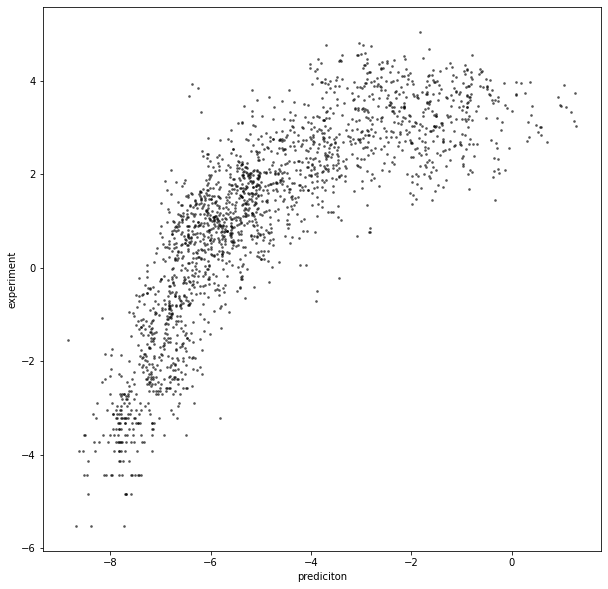

In [ ]:
#generate a scatter plot showing sxperiment and prediciton values
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, ax1 = plt.subplots(figsize=(10, 10))
pred_list = []
exper_list = []
pred_array = np.zeros((len(sequence_pd)*250,))
exper_array = np.zeros((len(sequence_pd)*250,))
for i in range(len(sequence_pd)):
    plt.scatter(np.log(np.mean(sequence_pd['prediction'].values[i])), np.log((np.mean(sequence_pd['experiment'].values[i]))), c='black', s=3, alpha=0.5)
    pred_list.append(np.mean(sequence_pd['prediction'].values[i]))
    exper_list.append(np.mean(sequence_pd['experiment'].values[i]))
    pred_array[i*250:i*250+250] = sequence_pd['prediction'].values[i]
    exper_array[i*250:i*250+250] = sequence_pd['experiment'].values[i]


plt.ylabel('experiment')
plt.xlabel('prediciton')
title = 'NFY_TATA_scatter_plot.pdf'
#plt.savefig('./figures/title, bbox_inches = 'tight')

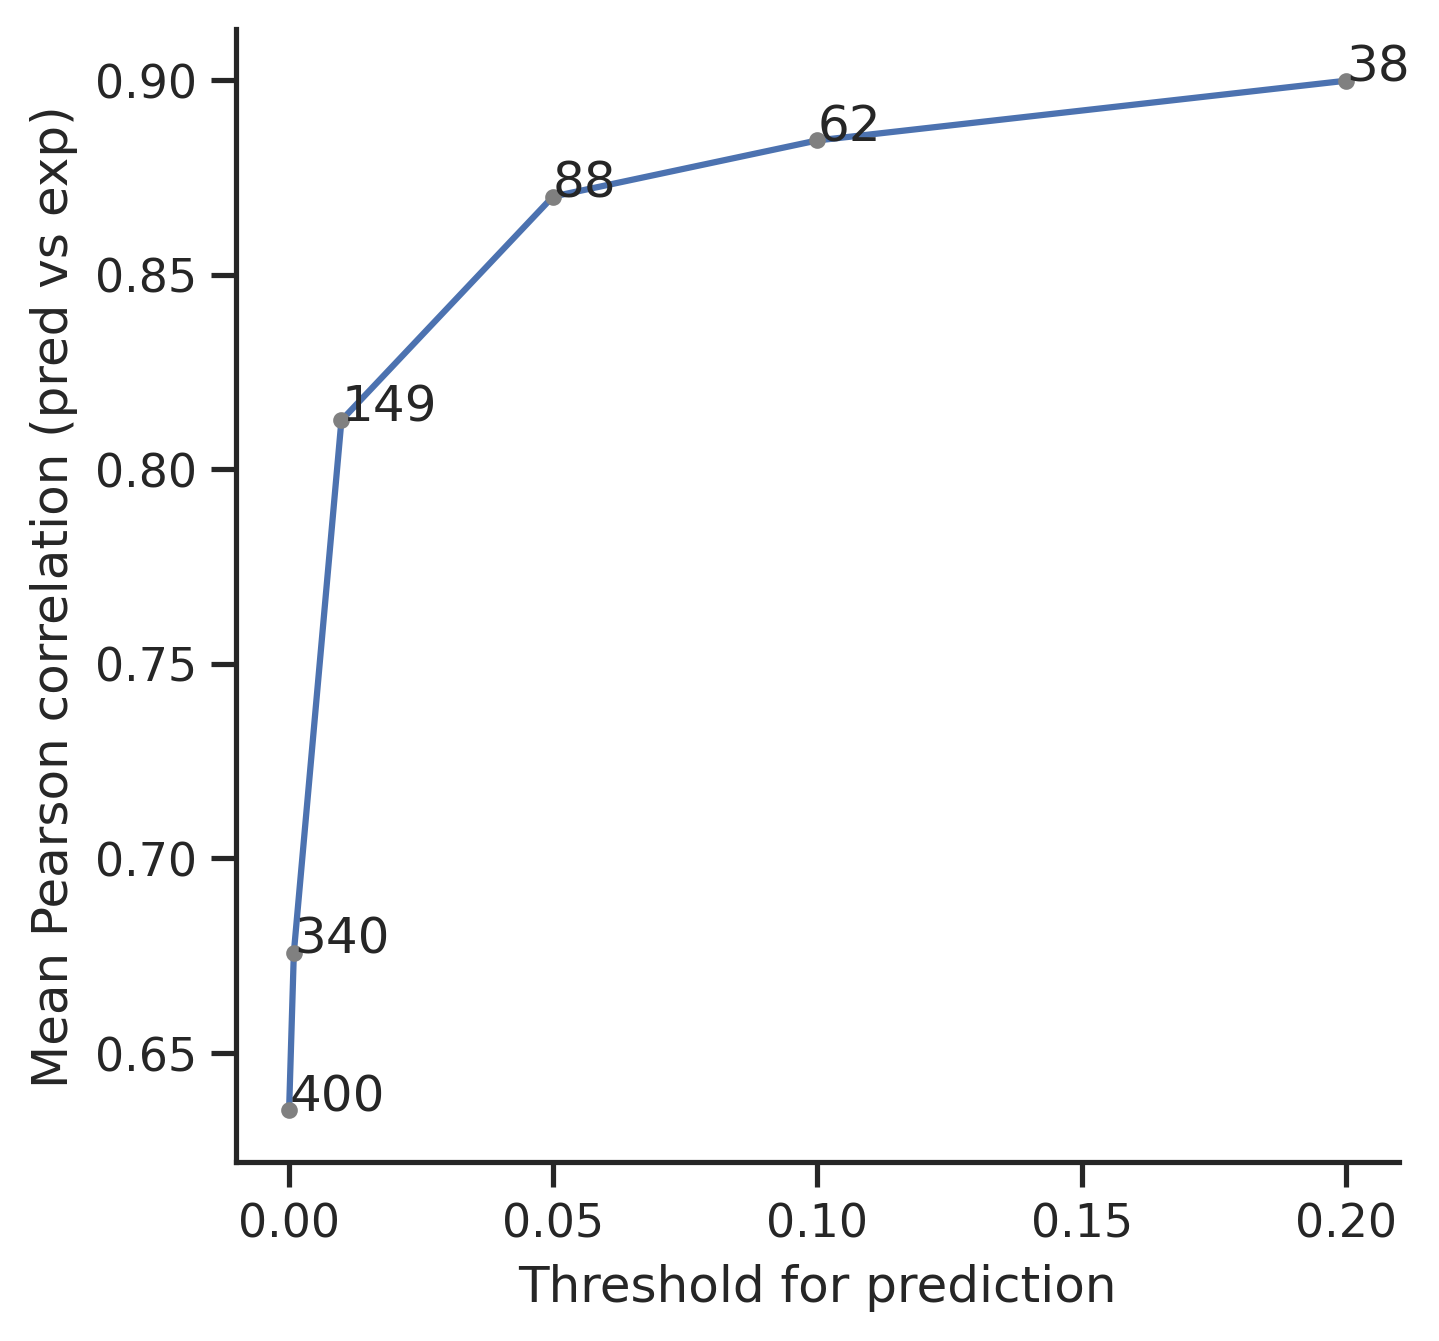

In [ ]:
cors = {}
back_list = list(OrderedDict.fromkeys(sequence_pd['background']))
thresholds = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]


for tresh in thresholds:
    cors[tresh] = []
all_cors = []
pred_mean_list = []

COLOR_pred = "#BE7F91"
COLOR_exp = "#3399e6"
for back in back_list:

    indeces = sequence_pd.loc[sequence_pd['background']==back].index
 

    for ii in range(0, len(indeces), 5):
        i = indeces[ii]
        pred_repl = np.zeros((5, 250))
        targ_repl = np.zeros((5, 250))
        for rep in range(5):
            pred_repl[rep,:] = np.array(sequence_pd['prediction'].values[i+rep])
            targ_repl[rep,:] = np.array(sequence_pd['experiment'].values[i+rep])
        pred = np.mean(pred_repl, axis=0)
        targ = np.mean(targ_repl, axis=0)
        pred_mean_list.append(np.mean(pred))
        cor = scipy.stats.pearsonr(pred, targ)
        all_cors.append(cor[0])
   
        for thresh in thresholds:
            if np.mean(pred)>(thresh):
                cors[thresh].append(cor[0])
                

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

cors_list = list(cors.keys())[:]
_, ax = plt.subplots(figsize=(5,5))
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style("white")

cor_mean_list = []
for key in cors_list:
    cor_mean_list.append(mean(cors[key]))

plt.plot(cors_list, cor_mean_list)
plt.plot(cors_list, cor_mean_list, '.', color='gray')
for key_n, key in enumerate(cors_list):
    plt.annotate(str(len(cors[key])), (key, cor_mean_list[key_n]))



plt.xlabel('Threshold for prediction')
plt.ylabel('Mean Pearson correlation (pred vs exp)')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
sns.despine()

title = 'NFY_TATA_correlation_plot.pdf'
#plt.savefig('./figures/'+title, bbox_inches = 'tight')

oligmoer index  440


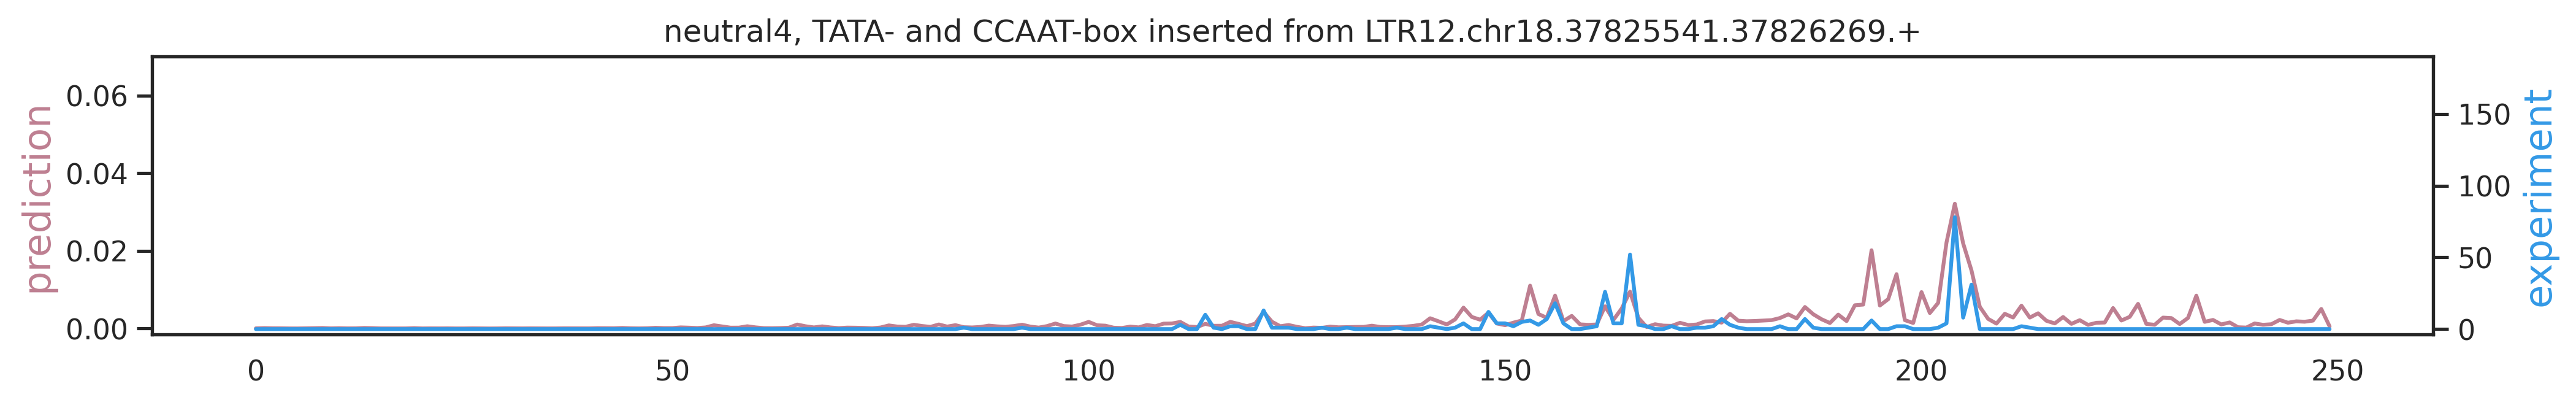

In [ ]:
#plot expriment and prediciton of the chosen oligomer
#here plotting the TATA and NFY insertions into the neutral sequence


back = 'neutral4'

#choose genometype
#genotype = 'wild-type'
#genotype = 'TATA-box inserted from LTR12.chr18.37825541.37826269.+'
#genotype = 'CCAAT-box inserted from LTR12.chr18.37825541.37826269.+'
genotype = 'TATA- and CCAAT-box inserted from LTR12.chr18.37825541.37826269.+'

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

indeces = sequence_pd.loc[(sequence_pd['background']==back) &(sequence_pd['genotype']==genotype)].index

COLOR_pred = "#BE7F91"
COLOR_exp = "#3399e6"


for ii in range(0, len(indeces), 2):
    i = indeces[ii]
    print('oligmoer index ', i)
    
    pred = np.array(sequence_pd['prediction'].values[i])
    targ = np.array(sequence_pd['experiment'].values[i])

    fig, ax1 = plt.subplots(figsize=(16, 2))

    ax2 = ax1.twinx()
    ax1.plot(pred, c=COLOR_pred)
    ax1.set_ylabel('prediction', c=COLOR_pred, fontsize=15)
    ax2.plot(targ, c=COLOR_exp)
    ax2.set_ylabel('experiment', c=COLOR_exp, fontsize=15)        
    plt.title(sequence_pd['background'][i]+', '+sequence_pd['genotype'][i])

    y1max = 0.07 
    y2max = 190 
    ax1.set_ylim(top=y1max)
    ax2.set_ylim(top=y2max)
    title = 'compact.'+back+'.'+genotype+'.pdf' 
    #plt.savefig('./figures/4/'+title, bbox_inches = 'tight')
    break
        


    

oligmoer index  440


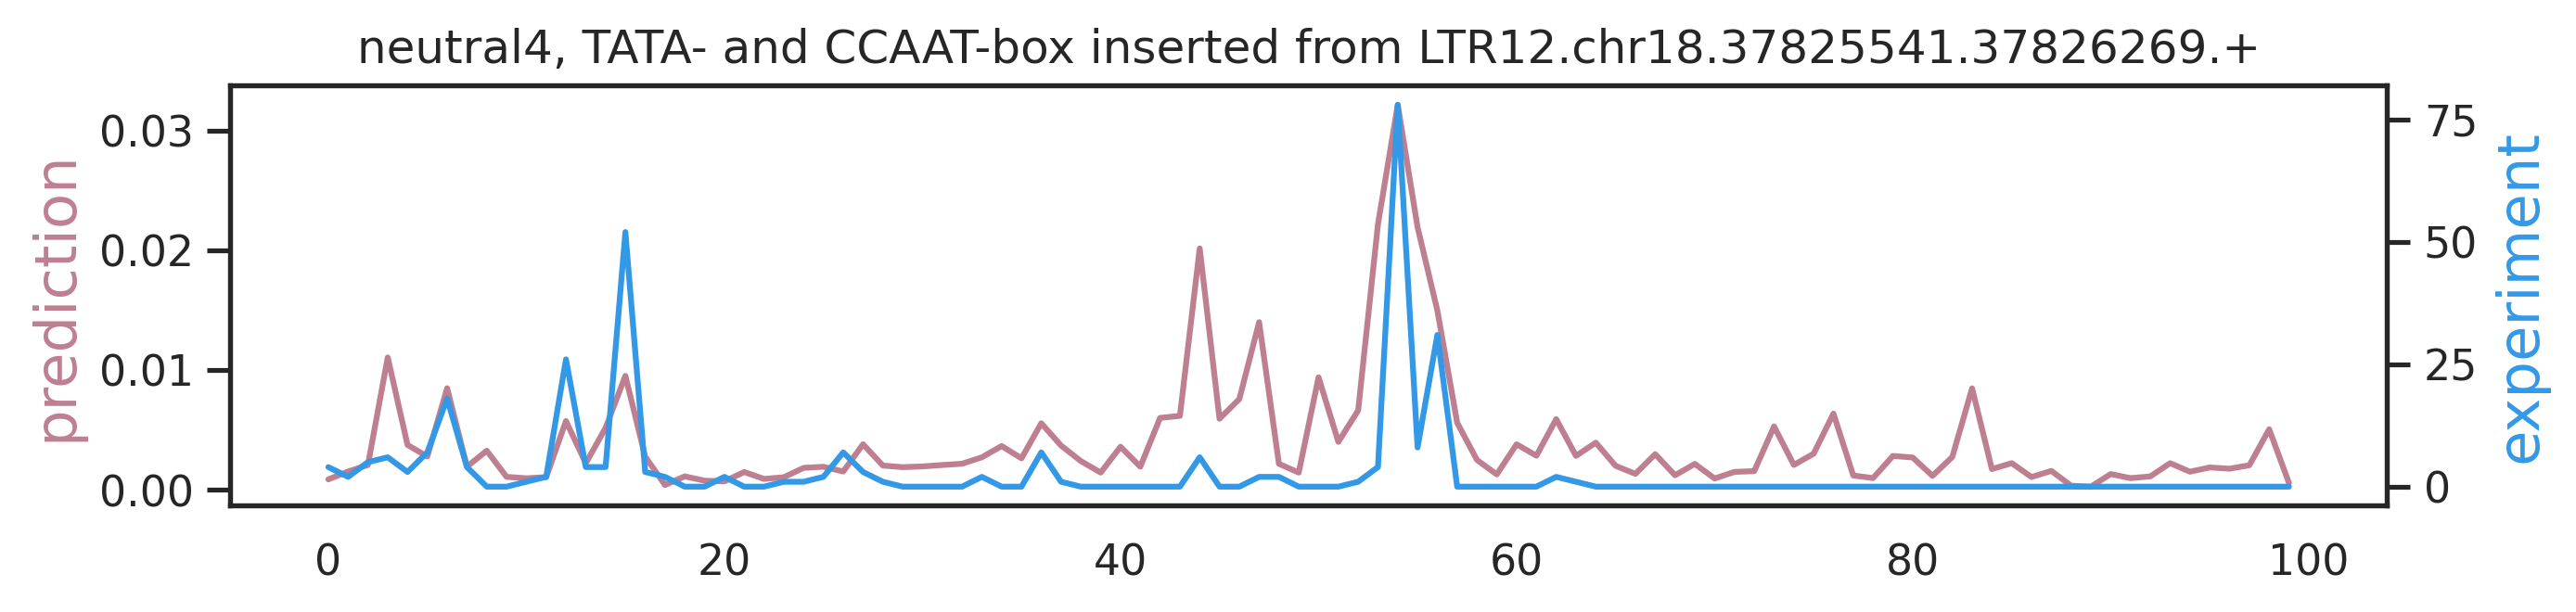

In [ ]:
#plot zoom-in version of the expriment and prediciton of the chosen oligomer
#here plotting the TATA and NFY insertions into the neutral sequence


back = 'neutral4'

#genotype = 'wild-type'
#genotype = 'TATA-box inserted from LTR12.chr18.37825541.37826269.+'
#genotype = 'CCAAT-box inserted from LTR12.chr18.37825541.37826269.+'
genotype = 'TATA- and CCAAT-box inserted from LTR12.chr18.37825541.37826269.+'

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

indeces = sequence_pd.loc[(sequence_pd['background']==back) &(sequence_pd['genotype']==genotype)].index

COLOR_pred = "#BE7F91"
COLOR_exp = "#3399e6"


for ii in range(0, len(indeces), 2):
    i = indeces[ii]
    print('oligmoer index ', i)
    

    pred = np.array(sequence_pd['prediction'].values[i])[150:]
    targ = np.array(sequence_pd['experiment'].values[i])[150:]

    fig, ax1 = plt.subplots(figsize=(10, 2))

    ax2 = ax1.twinx()
    ax1.plot(pred, c=COLOR_pred)
    ax1.set_ylabel('prediction', c=COLOR_pred, fontsize=15)
    ax2.plot(targ, c=COLOR_exp)
    ax2.set_ylabel('experiment', c=COLOR_exp, fontsize=15)

    plt.title(sequence_pd['background'][i]+', '+sequence_pd['genotype'][i])

    y1max = 2.5
    y2max = 4000
    
    title = 'compact.zoom_in.'+back+'.'+genotype+'.pdf'   
    #plt.savefig('./figure/'+title, bbox_inches = 'tight')
    break



oligmoer index  5


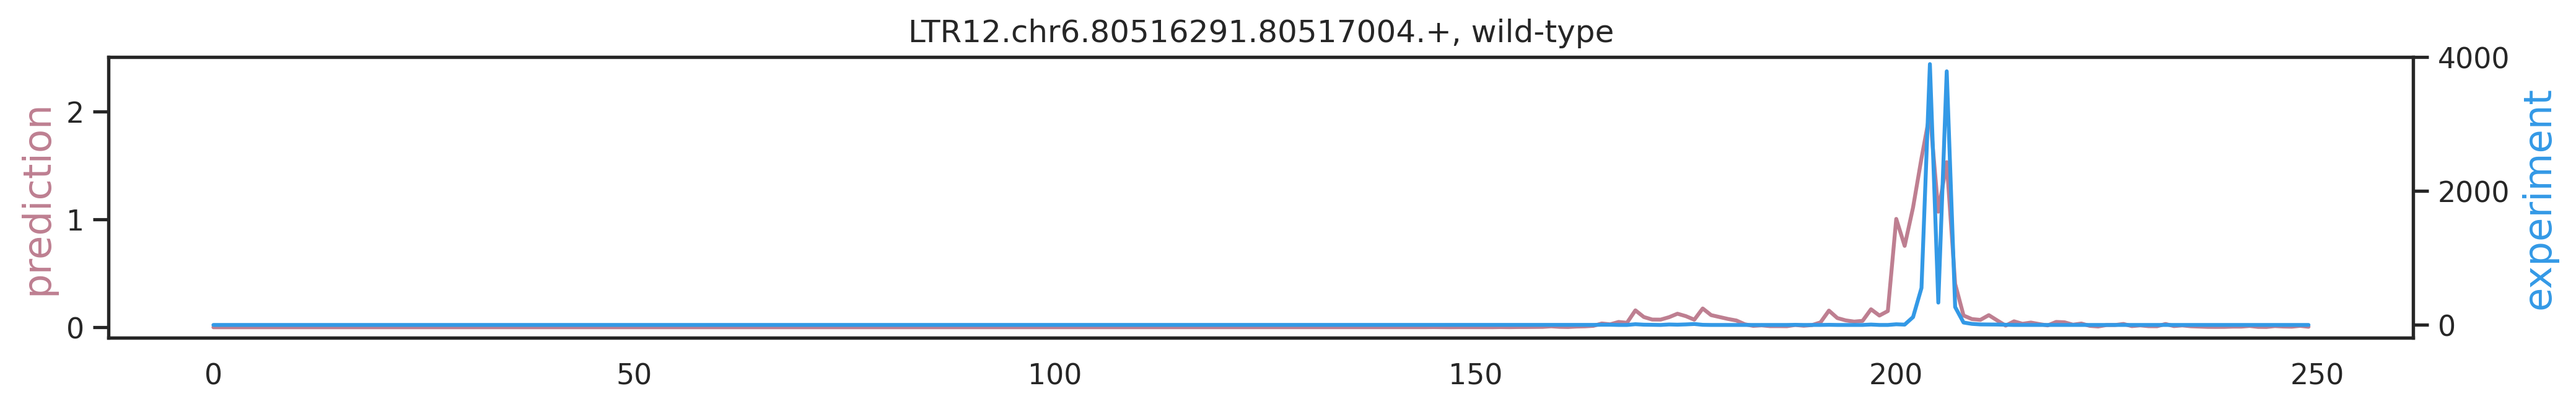

In [ ]:
#plot zoom-in version of the expriment and prediciton of the chosen oligomer
#here plotting the TATA and NFY mutations in LTR12

back = 'LTR12.chr6.80516291.80517004.+' #chose the background
genotype = 'wild-type'
#genotype = 'TATA-box mutated'
#genotype ='CCAAT-box mutated'
#genotype = 'TATA- and CCAAT-box mutated'

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

indeces = sequence_pd.loc[(sequence_pd['background']==back) &(sequence_pd['genotype']==genotype)].index

COLOR_pred = "#BE7F91"
COLOR_exp = "#3399e6"


for ii in range(0, len(indeces), 2):
    i = indeces[ii]
    print('oligmoer index ', i)
    
       
    pred = np.array(sequence_pd['prediction'].values[i])
    targ = np.array(sequence_pd['experiment'].values[i])

    fig, ax1 = plt.subplots(figsize=(16, 2))

    ax2 = ax1.twinx()
    ax1.plot(pred, c=COLOR_pred)
    ax1.set_ylabel('prediction', c=COLOR_pred, fontsize=15)
    ax2.plot(targ, c=COLOR_exp)
    ax2.set_ylabel('experiment', c=COLOR_exp, fontsize=15)

    plt.title(sequence_pd['background'][i]+', '+sequence_pd['genotype'][i])

    y1max = 2.5
    y2max = 4000
    ax1.set_ylim(top=y1max)
    ax2.set_ylim(top=y2max)
    title = 'compact.'+back+'.'+genotype+'.pdf'

    #plt.savefig('./figures/'+title, bbox_inches = 'tight')
    break




oligmoer index  5


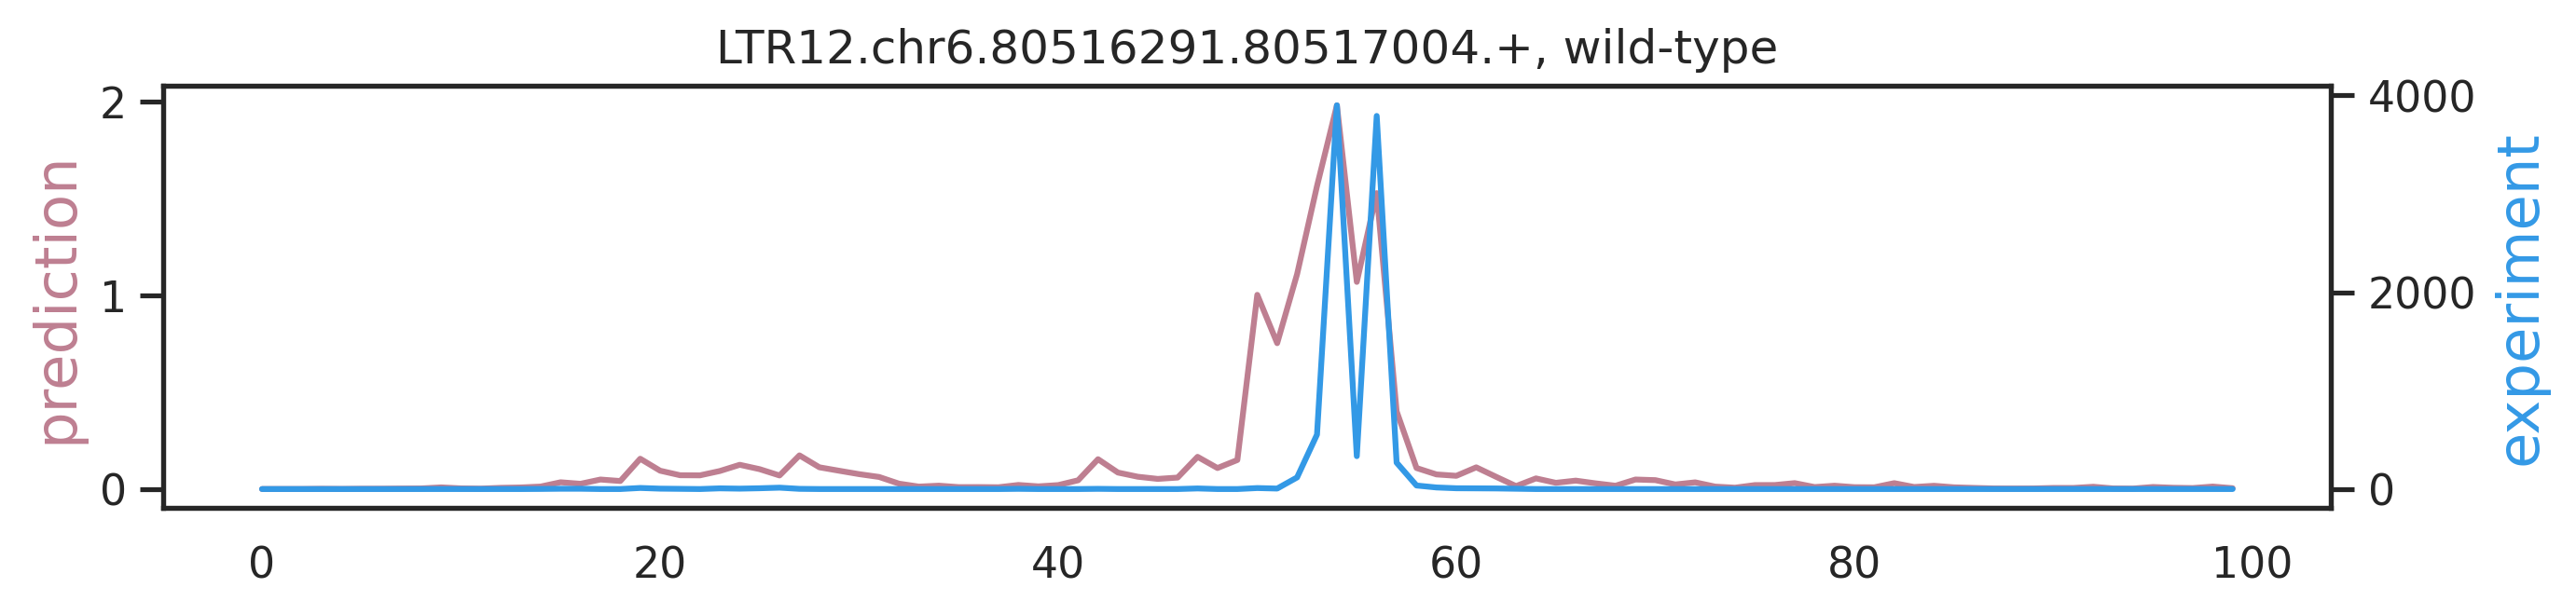

In [ ]:
#plot zoom-in version of the expriment and prediciton of the chosen oligomer
#here plotting the TATA and NFY mutations in LTR12

back = 'LTR12.chr6.80516291.80517004.+' #chose the background
genotype = 'wild-type'
#genotype = 'TATA-box mutated'
#genotype ='CCAAT-box mutated'
#genotype = 'TATA- and CCAAT-box mutated'

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

indeces = sequence_pd.loc[(sequence_pd['background']==back) &(sequence_pd['genotype']==genotype)].index

COLOR_pred = "#BE7F91"
COLOR_exp = "#3399e6"


for ii in range(0, len(indeces), 2):
    i = indeces[ii]
    print('oligmoer index ', i)
    

    pred = np.array(sequence_pd['prediction'].values[i])[150:]
    targ = np.array(sequence_pd['experiment'].values[i])[150:]

    fig, ax1 = plt.subplots(figsize=(10, 2))

    ax2 = ax1.twinx()
    ax1.plot(pred, c=COLOR_pred)
    ax1.set_ylabel('prediction', c=COLOR_pred, fontsize=15)
    ax2.plot(targ, c=COLOR_exp)
    ax2.set_ylabel('experiment', c=COLOR_exp, fontsize=15)

    plt.title(sequence_pd['background'][i]+', '+sequence_pd['genotype'][i])

    y1max = 2.5
    y2max = 4000
    
    title = 'compact.zoom_in.'+back+'.'+genotype+'.pdf'   
    #plt.savefig('./figure/'+title, bbox_inches = 'tight')
    break